<a href="https://colab.research.google.com/github/itchyfeet-patient/kaggle-transcription/blob/master/Simple_Feature_Engg_Notebook_Spooky_Author.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simple Feature Engg Notebook - Spooky Author ✍

[원본 노트북](https://www.kaggle.com/code/sudalairajkumar/simple-feature-engg-notebook-spooky-author/notebook)

오싹오싹 작가모음 ><  
대회목적:  
1. 에드거 앨런 포 
2. hp 러브크래프트
3. 마리 쉘리 (프랑켄슈타인)   

이 세 작가들의 소설이 담긴 text를 가지고 test셋에서 주어진 문장의 저자를 정확하게 식별해내는 것입니다!  

이 노트북의 목적!:
예측에 도움될 다양한 기능을 만들어 볼거에요!  
일단, EDA part에 돌입하기 전 기초적인 데이터 시각화와 cleaning을 해보겠어요~!

In [9]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import string
import xgboost as xgb
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn import ensemble, metrics, model_selection, naive_bayes
color = sns.color_palette()

%matplotlib inline

eng_stopwords = set(stopwords.words("english"))
pd.options.mode.chained_assignment = None

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
## Read the train and test dataset and check the top few lines
train_df = pd.read_csv("/content/drive/MyDrive/dataset/kaggle/spooky-author-identification/train/train.csv")
test_df = pd.read_csv("/content/drive/MyDrive/dataset/kaggle/spooky-author-identification/test/test.csv")
print("Number of rows in train dataset : ", train_df.shape[0])
print("Number of rows in test dataset : ", test_df.shape[0])


Number of rows in train dataset :  19579
Number of rows in test dataset :  8392


In [11]:
train_df.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


클래스가 균형있게 이뤄져잇는지 한번 작가별 텍스트 개수를 체크해봅시다.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


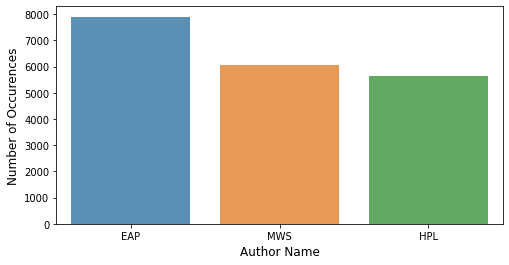

In [12]:
cnt_srs = train_df['author'].value_counts()

plt.figure(figsize=(8,4))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8)
plt.ylabel('Number of Occurences', fontsize=12)
plt.xlabel('Author Name', fontsize=12)
plt.show()

균형있게 클래스가 분포돼있습니다. 저자의 글 스타일을 이해하기 위해 몇줄 출력해봅시다.

In [13]:
grouped_df = train_df.groupby('author')
for name, group in grouped_df:
    print(group)

            id                                               text author
0      id26305  This process, however, afforded me no means of...    EAP
2      id11008  In his left hand was a gold snuff box, from wh...    EAP
6      id09674  The astronomer, perhaps, at this point, took r...    EAP
7      id13515        The surcingle hung in ribands from my body.    EAP
8      id19322  I knew that you could not say to yourself 'ste...    EAP
...        ...                                                ...    ...
19572  id03325  But these and other difficulties attending res...    EAP
19574  id17718  I could have fancied, while I looked at it, th...    EAP
19575  id08973  The lids clenched themselves together as if in...    EAP
19576  id05267  Mais il faut agir that is to say, a Frenchman ...    EAP
19577  id17513  For an item of news like this, it strikes us i...    EAP

[7900 rows x 3 columns]
            id                                               text author
1      id17569  It never o

저자명으로 그룹화를 시켰으니까 나머지 정보는 위와 같이 group 되어있습니다. 이를 이용해서 text column 을 5줄 출력해보겠습니다.

In [14]:
grouped_df = train_df.groupby('author')
for name, group in grouped_df:
    print("author name : ", name)
    cnt = 0
    for ind, row in group.iterrows():
        # iterrows : 데이터의 행-열/데이터 정보를 (행이름, (열-값))
        print(row["text"])
        cnt += 1
        if cnt == 5:
            break
    print("\n")


author name :  EAP
This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I might make its circuit, and return to the point whence I set out, without being aware of the fact; so perfectly uniform seemed the wall.
In his left hand was a gold snuff box, from which, as he capered down the hill, cutting all manner of fantastic steps, he took snuff incessantly with an air of the greatest possible self satisfaction.
The astronomer, perhaps, at this point, took refuge in the suggestion of non luminosity; and here analogy was suddenly let fall.
The surcingle hung in ribands from my body.
I knew that you could not say to yourself 'stereotomy' without being brought to think of atomies, and thus of the theories of Epicurus; and since, when we discussed this subject not very long ago, I mentioned to you how singularly, yet with how little notice, the vague guesses of that noble Greek had met with confirmation in the late nebular cosmogony, I felt that you coul

텍스트데이터에 꽤 많은 특수문자가 있다는 점을 알 수 있습니다. 그래서 이 특수문자들은 좋은 feature가 될 수 있을거에요! 나중에 만들어봅시다.  
그거말고는.. 딱히..  
**Feature Engineering:**  
자 이제 몇가지 feature engineering을 해보겠어요. 
1. Meta features - 단어 수 , stopwords 수, 구두점 수 등과 같은 텍스트에서 추출된 features.
2. Text based features - 빈도수, svd, word2vec 등과 같이 텍스트/단어를 직접 기반으로 하는 feature
**Meta Features:**
이제 메타 feature를 만드는 것 부터 시작해서 얼마나 작가를 잘 예측하는지 봅시다. feature list는 다음과 같습니다.

1. Number of words in the text
2. Number of unique words in the text
3. Number of characters in the text
4. Number of stopwords
5. Number of punctuations
6. Number of upper case words
7. Number of title case words
8. Average length of the words

In [15]:
## Number of words in the text ##
train_df["num_words"] = train_df["text"].apply(lambda x: len(str(x).split()))
test_df["num_words"] = test_df["text"].apply(lambda x: len(str(x).split()))

## Number of unique words in the text ##
train_df["num_unique_words"] = train_df["text"].apply(lambda x: len(set(str(x).split())))
test_df["num_unique_words"] = test_df["text"].apply(lambda x: len(set(str(x).split())))

## Number of characters in the text ##
train_df["num_chars"] = train_df["text"].apply(lambda x: len(str(x)))
test_df["num_chars"] = train_df["text"].apply(lambda x: len(str(x)))

## Number of stopwords in the text ##
train_df["num_stopwords"] = train_df["text"].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))
test_df["num_stopwords"] = test_df["text"].apply(lambda x : len([w for w in str(x).lower().split() if w in eng_stopwords]))

## Number of punctuations in the text ##
train_df["num_punctuations"] = train_df["text"].apply(lambda x : len([c for c in str(x) if c in string.punctuation]))
test_df["num_punctuations"] = test_df["text"].apply(lambda x : len([c for c in str(x) if c in string.punctuation]))

## Number of tilte case words in the text ##
train_df["num_words_upper"] = train_df["text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
test_df["num_words_upper"] = test_df["text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

## Number of length of the words in the text ##
train_df["mean_word_len"] = train_df["text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test_df["mean_word_len"] = test_df["text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))


In [18]:
train_df.head(5)

,id,text,author,num_words,num_unique_words,num_chars,num_stopwords,num_punctuations,num_words_upper,mean_word_len
0,id26305,"This process, however, afforded me no means of...",EAP,41,35,231,19,7,2,4.658537
1,id17569,It never once occurred to me that the fumbling...,HPL,14,14,71,8,1,0,4.142857
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP,36,32,200,16,5,0,4.583333
3,id27763,How lovely is spring As we looked from Windsor...,MWS,34,32,206,13,4,0,5.088235
4,id12958,"Finding nothing else, not even gold, the Super...",HPL,27,25,174,11,4,0,5.481481


Let's now plot some of our new variable to see of they will be helpful in predictions.  
그림그려보자~!

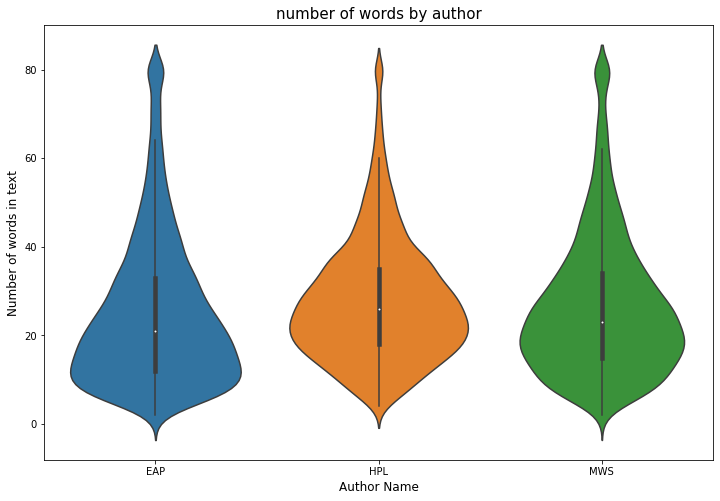

In [16]:
train_df["num_words"].loc[train_df["num_words"]>80] = 80
# truncation for better visuals 글자수 80이상은 80으로 하자!
plt.figure(figsize=(12,8))
sns.violinplot(x='author', y='num_words', data=train_df)
plt.xlabel('Author Name', fontsize=12)
plt.ylabel('Number of words in text', fontsize=12)
plt.title("number of words by author", fontsize=15)
plt.show()

EAP는 상대적으로 적은 단어수를 갖고있어요

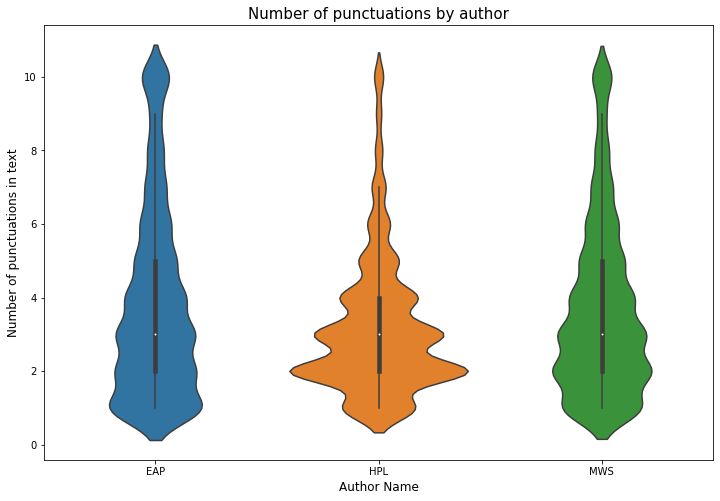

In [20]:
train_df['num_punctuations'].loc[train_df['num_punctuations']>10] = 10
# truncation for better visuals punctuation이 10개 넘으면 10개로 걍 쳐요
plt.figure(figsize=(12,8))
sns.violinplot(x = 'author', y='num_punctuations', data=train_df)
plt.xlabel('Author Name', fontsize=12)
plt.ylabel('Number of punctuations in text', fontsize=12)
plt.title('Number of punctuations by author', fontsize=15)
plt.show()

이것도 좀 쓸만해보임. 텍스트기반 feature를 만드는데 집중해보즈아  
이런 메타 feature가 어떻게 도움이 되는 지 알아보기 위해서 먼저 basic model을 구축해보겠어요

In [23]:
## Prepare the data for modeling ##
author_mapping_dict = {'EAP':0, 'HPL':1, 'MWS':2}
# 맵핑을해줘요
train_y =train_df['author'].map(author_mapping_dict)
# 리얼 맵핑을 해줘요
train_id = train_df['id'].values
# id 값들 train_id에 넣어줘요 배열형태로 들어가요
test_id = test_df['id'].values

### recompute the truncated variables again ###
train_df["num_words"] = train_df["text"].apply(lambda x: len(str(x).split()))
test_df["num_words"] = test_df["text"].apply(lambda x: len(str(x).split()))
train_df["mean_word_len"] = train_df["text"].apply(lambda x : np.mean([len(w) for w in str(x).split()]))
test_df["mean_word_len"] = test_df["text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

cols_to_drop = ['id', 'text']
train_X = train_df.drop(cols_to_drop + ['author'], axis=1)
test_X = test_df.drop(cols_to_drop, axis =1)

We can train a simple XGBoost model with these meta features alone.

In [31]:
def runXGB(train_X, train_y, test_X, test_y=None, test_X2=None, seed_val=0, child=1, colsample=0.3):
    param = {}
    param['objective'] = 'multi:softprob'
    param['eta'] = 0.1
    param['max_depth'] = 3
    param['silent'] = 1
    param['num_class'] = 3
    param['eval_metric'] = "mlogloss"
    param['min_child_weight'] = child
    param['subsample'] = 0.8
    param['colsample_bytree'] = colsample
    param['seed'] = seed_val
    num_rounds = 2000
    # 하이퍼파라미터

    plst = list(param.items())
    xgtrain = xgb.DMatrix(train_X, label=train_y)

    if test_y is not None:
        xgtest = xgb.DMatrix(test_X, label=test_y)
        watchlist = [ (xgtrain,'train'), (xgtest, 'test') ]
        model = xgb.train(plst, xgtrain, num_rounds, watchlist, early_stopping_rounds=50, verbose_eval=20)
    else:
        xgtest = xgb.DMatrix(test_X)
        model = xgb.train(plst, xgtrain, num_rounds)

    pred_test_y = model.predict(xgtest, ntree_limit = model.best_ntree_limit)
    if test_X2 is not None:
        xgtest2 = xgb.DMatrix(test_X2)
        pred_test_y2 = model.predict(xgtest2, ntree_limit = model.best_ntree_limit)
    return pred_test_y, pred_test_y2, model

x2는 뭔교

커널 실행 시간을 위해 점수에 대한 k-fold 교차검증의 첫번째 폴드만 확인할 수 있습니다. 로컬에서 실행하는동안에는 중단 줄을 제거하셈

In [32]:
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 3])
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_X.loc[dev_index], train_X.loc[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runXGB(dev_X, dev_y, val_X, val_y, test_X, seed_val=0)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
    break
print("cv scores : ", cv_scores)

[0]	train-mlogloss:1.09356	test-mlogloss:1.09448
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 50 rounds.
[20]	train-mlogloss:1.03981	test-mlogloss:1.05069
[40]	train-mlogloss:1.02304	test-mlogloss:1.0394
[60]	train-mlogloss:1.01197	test-mlogloss:1.03199
[80]	train-mlogloss:1.00303	test-mlogloss:1.02654
[100]	train-mlogloss:0.99584	test-mlogloss:1.02209
[120]	train-mlogloss:0.988838	test-mlogloss:1.01712
[140]	train-mlogloss:0.982641	test-mlogloss:1.01406
[160]	train-mlogloss:0.977904	test-mlogloss:1.01173
[180]	train-mlogloss:0.972682	test-mlogloss:1.00946
[200]	train-mlogloss:0.969084	test-mlogloss:1.00849
[220]	train-mlogloss:0.965384	test-mlogloss:1.0072
[240]	train-mlogloss:0.961478	test-mlogloss:1.00539
[260]	train-mlogloss:0.958299	test-mlogloss:1.00442
[280]	train-mlogloss:0.955439	test-mlogloss:1.00362
[300]	train-mlogloss:0.952471	test-mlogloss:1.00341
[320]	train-mlogloss:0.949371	t

meta feature를 이용해서 mlogloss 1.0010을 얻었어용.. 좋은데?   
이제 이런 feature 중 어떤 것이 중요한지 봅시다

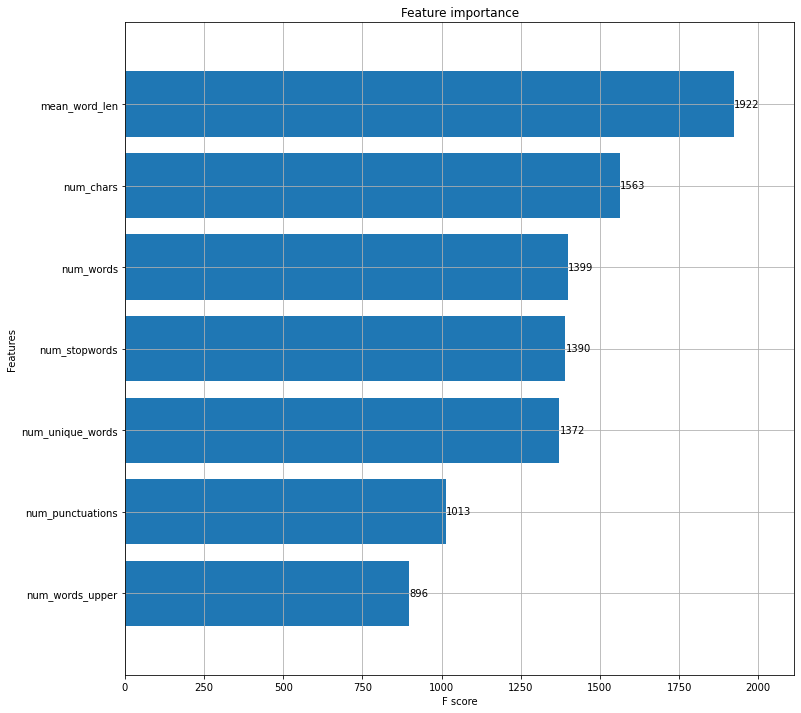

In [34]:
## plot the important variables ##
fig, ax = plt.subplots(figsize=(12,12))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()

원 노트북이랑 살쟉 다르네요  
글자개수, 평균 단어길이, 단어 개수가 상위3개네요

Text Based Features:  
우리가 만들 수 있는 기본 기능 중 하나는 텍스트에 있는 단어의 tf-idf 값입니다. 그걸로 함 시작해봅시다

In [35]:
## Fit transform the tfidf vectorizer ##
tfidf_vec = TfidfVectorizer(stop_words = 'english', ngram_range=(1,3))
full_tfidf = tfidf_vec.fit_transform(train_df['text'].values.tolist()+test_df['text'].values.tolist())
train_tfidf=tfidf_vec.transform(train_df['text'].values.tolist())
test_tfidf = tfidf_vec.transform(test_df['text'].values.tolist())


자 이제 tfidf 벡터를 얻었는데요? 여기 까다로운 부분이 있어요.  
tfidf 출력은 sparse matrix라서 다른 dense feature들과 함께 사용하기 위해서는 몇가지 선택사항이 있어요
1. tfidf 벡터라이저에서 상위 n번째 기능을 가져오도록 선택하고 이를 dense 포맷으로 변환하고 다른 기능과 연결할 수 있다!
2. sparse feature만 사용해서 모델을 작성하고 다른 dense feature와 feature중 하나로 예측을 사용.  

데이터셋을 기반하면, 하나가 다른 하나보다 더 잘 수행될 수 있습니다.
여기서 우리는 tfidf 의 모든 기능을 사용하는 아주 좋은 스코어링 커널이 있기 때문에 두번째 접근 방식을 사용할 수 있어용    

또한 naive bayes가 이 데이터셋에서 더 나은 성능을 보이는 것 같습니다. 따라서 tfidf  기능을 사용해서 학습 속도가 더 빠르기 때문에 나이브베이즈 모델을 구축할 수 있습니다.

In [38]:
def runMNB(train_X, train_y, test_X, test_y, test_X2):
    model = naive_bayes.MultinomialNB()
    model.fit(train_X, train_y)
    pred_test_y = model.predict_proba(test_X)
    pred_test_y2 = model.predict_proba(test_X2)
    return pred_test_y, pred_test_y2, model

tfidf vectorizer에서 나이브베이즈

In [40]:
cv_scores=[]
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 3])
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runMNB(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index, :] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))

print("Mean cv scores : ", np.mean(cv_scores))
pred_full_test = pred_full_test / 5.

Mean cv scores :  0.8422161983612855


소름돋게도 거의 원 노트북과 같네요! (당연함)

0.842정도의 mlogloss를 얻엇습니당! 메타데이터가 저는 더 좋았어요! ; 왜죠 ? confusion matrix 함봅시다

In [44]:
### function to create confusion matrix ##
import itertools
from sklearn.metrics import confusion_matrix

### from http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py #
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting 'normalize=True'
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment='center',
                 color='white' if cm[i, j] > thresh else "black")
    plt.tight_layout() 
    plt.ylabel('True lalbe')
    plt.xlabel('Predicted label')

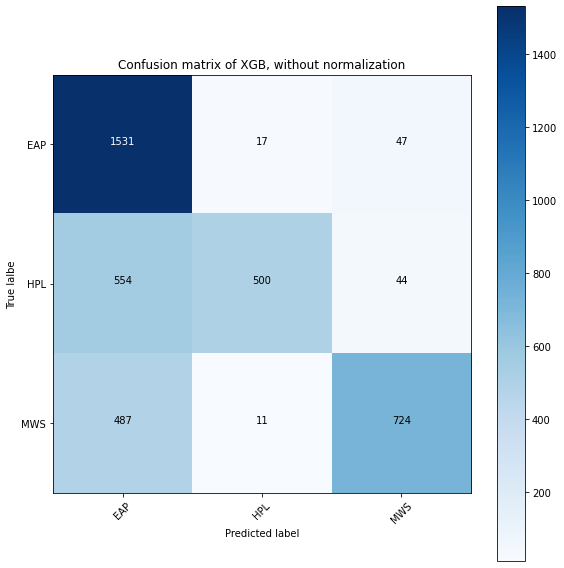

In [45]:
cnf_matrix = confusion_matrix(val_y, np.argmax(pred_val_y,axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes=['EAP', 'HPL', 'MWS'],
                      title='Confusion matrix of XGB, without normalization')
plt.show()

많은 인스턴스가  EAP로 예측되고 해당 클래스에 크게 치우쳐 있당..   
SVD on word TFIDF:  
tfidf 벡터가 희박하기 때문에 정보를 압축하고 훨씬 간결하게 표현하는 또 다른 방법은 SVD를 사용하는겁니다!   
그리고 일반적으로 svd기능은 과거 텍스트기반 대회에서 잘 수행댔습니다 일단 저한테는요 ^^  
그래서 tfidf에다가 svd 기능을 만들고 기능세트에 추가할거에욛ㅇ

In [47]:
n_comp = 20
svd_obj = TruncatedSVD(n_components = n_comp, algorithm='arpack')
svd_obj.fit(full_tfidf)
train_svd = pd.DataFrame(svd_obj.transform(train_tfidf))
test_svd = pd.DataFrame(svd_obj.transform(test_tfidf))

train_svd.columns = ['svd_word_' +str(i) for i in range(n_comp)]
test_svd.columns = ['svd_word_' +str(i) for i in range(n_comp)]
train_df = pd.concat([train_df, train_svd], axis=1)
test_df = pd.concat([test_df, test_svd], axis =1)
del full_tfidf, train_tfidf, test_tfidf, train_svd, test_svd

나이브베이즈 on count vectorizer:

In [48]:
### fit transform the count vectorizer ###
tfidf_vec = CountVectorizer(stop_words = 'english', ngram_range=(1,3))
tfidf_vec.fit(train_df['text'].values.tolist() + test_df['text'].values.tolist())
train_tfidf = tfidf_vec.transform(train_df['text'].values.tolist())
test_tfidf = tfidf_vec.transform(test_df['text'].values.tolist())

이제 feature를 기반으로 한 count vectorizer를 사용해서 multinomial 나이브 베이즈 모델을 만들어볼거에용

In [51]:
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 3])
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runMNB(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print("Mean cv score : ", np.mean(cv_scores))
pred_full_test = pred_full_test / 5.

# add the predictions as new features #
train_df["nb_cvec_eap"] = pred_train[:,0]
train_df["nb_cvec_hpl"] = pred_train[:,1]
train_df["nb_cvec_mws"] = pred_train[:,2]
test_df["nb_cvec_eap"] = pred_full_test[:,0]
test_df["nb_cvec_hpl"] = pred_full_test[:,1]
test_df["nb_cvec_mws"] = pred_full_test[:,2]

Mean cv score :  0.45091841616567435


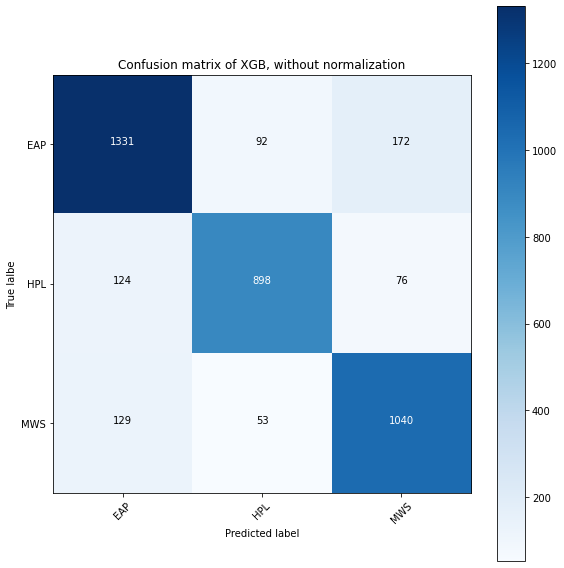

In [52]:
cnf_matrix = confusion_matrix(val_y, np.argmax(pred_val_y,axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes=['EAP', 'HPL', 'MWS'],
                      title='Confusion matrix of XGB, without normalization')
plt.show()

wow tfidf vectorizer대신에  count vectorizer사용했더니 0.45 의 mlogloss를 얻어버렸어요  
이 모델을 사용한 LB 점수는 0.468입니다 글고 confusion matrix 보면 더 좋아보입니다. 안 치우쳐잇고?

Naive Bayes on Character count vectorizer:  
데이터 아이볼링의 한 가지 아이디어는 특수문자를 계산하는게 도움이 되 수 있다는거임  
특수문자를 계산하는 대신 문자 수준에서 count vectorizer를 사용해서 일부 기능을 쓸 수 있어용 다시 multinomial nb를 해봅시당

In [55]:
## fit transform the tfidf vectorizer ##
tfidf_vec = CountVectorizer(ngram_range=(1,7), analyzer = 'char')
tfidf_vec.fit(train_df['text'].values.tolist() + test_df['text'].values.tolist())
train_tfidf = tfidf_vec.transform(train_df['text'].values.tolist())
test_tfidf = tfidf_vec.transform(test_df['text'].values.tolist())

cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 3])
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2022)
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runMNB(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print("Mean cv score : ", np.mean(cv_scores))
pred_full_test = pred_full_test / 5.

# add the predictions as new features #
train_df["nb_cvec_char_eap"] = pred_train[:,0]
train_df["nb_cvec_char_hpl"] = pred_train[:,1]
train_df["nb_cvec_char_mws"] = pred_train[:,2]
test_df["nb_cvec_char_eap"] = pred_full_test[:,0]
test_df["nb_cvec_char_hpl"] = pred_full_test[:,1]
test_df["nb_cvec_char_mws"] = pred_full_test[:,2]

Mean cv score :  3.765812521380835


cross val  점수가 매우 높습니다. 근데 이건 단어수준 기능고ㅏ 다른 정보를 추가할수 있으니까.. 최종 모델에도 사용하도록하겠습니당
character tfidf vectorizer의 naive bayes:   
character tfidf vectorizer에 대해 nb 예측을 얻도록 합쉬다

In [56]:
### Fit transform the tfidf vectorizer ###
tfidf_vec = TfidfVectorizer(ngram_range=(1,5), analyzer='char')
full_tfidf = tfidf_vec.fit_transform(train_df['text'].values.tolist() + test_df['text'].values.tolist())
train_tfidf = tfidf_vec.transform(train_df['text'].values.tolist())
test_tfidf = tfidf_vec.transform(test_df['text'].values.tolist())

cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 3])
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runMNB(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print("Mean cv score : ", np.mean(cv_scores))
pred_full_test = pred_full_test / 5.

# add the predictions as new features #
train_df["nb_tfidf_char_eap"] = pred_train[:,0]
train_df["nb_tfidf_char_hpl"] = pred_train[:,1]
train_df["nb_tfidf_char_mws"] = pred_train[:,2]
test_df["nb_tfidf_char_eap"] = pred_full_test[:,0]
test_df["nb_tfidf_char_hpl"] = pred_full_test[:,1]
test_df["nb_tfidf_char_mws"] = pred_full_test[:,2]

Mean cv score :  0.790415258947421


SVD on character tfidf:  
우린이제 character feature에 svd feature를 만들고 모델링에 사용할수도있어요

In [57]:
n_comp = 20
svd_obj = TruncatedSVD(n_components=n_comp, algorithm='arpack')
svd_obj.fit(full_tfidf)
train_svd = pd.DataFrame(svd_obj.transform(train_tfidf))
test_svd = pd.DataFrame(svd_obj.transform(test_tfidf))
    
train_svd.columns = ['svd_char_'+str(i) for i in range(n_comp)]
test_svd.columns = ['svd_char_'+str(i) for i in range(n_comp)]
train_df = pd.concat([train_df, train_svd], axis=1)
test_df = pd.concat([test_df, test_svd], axis=1)
del full_tfidf, train_tfidf, test_tfidf, train_svd, test_svd

XGboost model:  
이제 이 새로운 변수들로, xgboost model을 다시 돌려볼수있겠죠

In [58]:
cols_to_drop = ['id', 'text']
train_X = train_df.drop(cols_to_drop+['author'], axis=1)
test_X = test_df.drop(cols_to_drop, axis=1)

kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 3])
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_X.loc[dev_index], train_X.loc[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runXGB(dev_X, dev_y, val_X, val_y, test_X, seed_val=0, colsample=0.7)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
    break
print("cv scores : ", cv_scores)

out_df = pd.DataFrame(pred_full_test)
out_df.columns = ['EAP', 'HPL', 'MWS']
out_df.insert(0, 'id', test_id)
out_df.to_csv("sub_fe.csv", index=False)

[0]	train-mlogloss:1.00679	test-mlogloss:1.00722
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 50 rounds.
[20]	train-mlogloss:0.409506	test-mlogloss:0.414457
[40]	train-mlogloss:0.337543	test-mlogloss:0.351226
[60]	train-mlogloss:0.311783	test-mlogloss:0.333948
[80]	train-mlogloss:0.295022	test-mlogloss:0.325272
[100]	train-mlogloss:0.281513	test-mlogloss:0.319222
[120]	train-mlogloss:0.270161	test-mlogloss:0.315605
[140]	train-mlogloss:0.260877	test-mlogloss:0.312394
[160]	train-mlogloss:0.252355	test-mlogloss:0.31074
[180]	train-mlogloss:0.244961	test-mlogloss:0.309918
[200]	train-mlogloss:0.237726	test-mlogloss:0.308678
[220]	train-mlogloss:0.231381	test-mlogloss:0.307962
[240]	train-mlogloss:0.22482	test-mlogloss:0.307506
[260]	train-mlogloss:0.219102	test-mlogloss:0.307134
[280]	train-mlogloss:0.213005	test-mlogloss:0.307057
[300]	train-mlogloss:0.207052	test-mlogloss:0.306846
[320]	train

val 0.3049, LB 0.32  
모든 폴드에서 실행하면 더 나은 점수를 얻을 수 있다

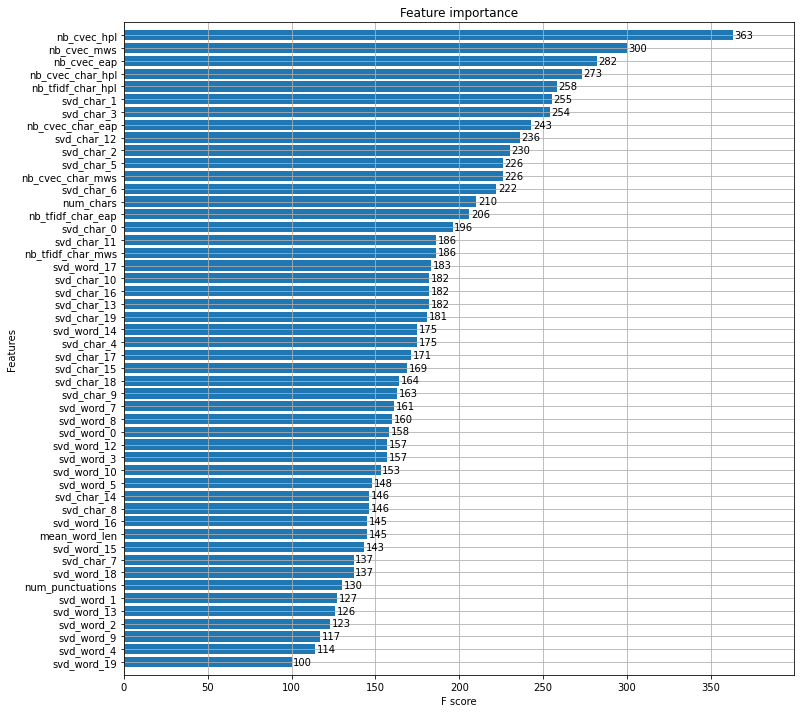

In [59]:
### Plot the important varialbes ###
fig, ax = plt.subplots(figsize=
                       (12,12))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()

나이브베이즈 feature가 성능이 제일 좋네요. 오분류 오류를 봅시다.

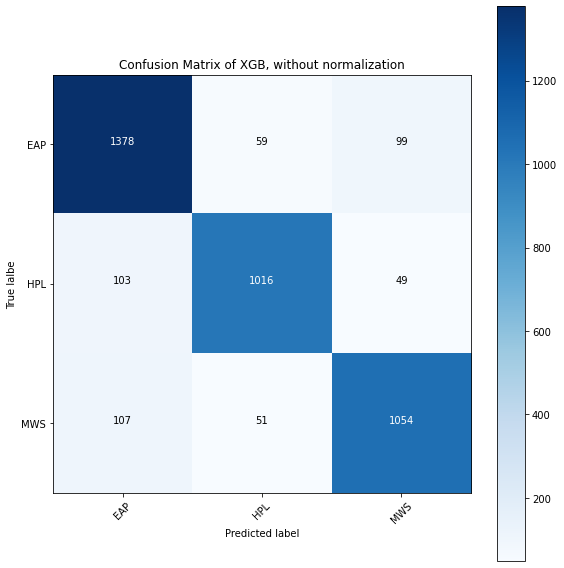

In [62]:
cnf_matrix = confusion_matrix(val_y, np.argmax(pred_val_y, axis=1))
np.set_printoptions(precision=2)

## plot non-normalized confusion matrix
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes=['EAP', 'HPL', 'MWS'], 
                      title = 'Confusion Matrix of XGB, without normalization')
plt.show()

EAP와 MWS는 다른 것들보다 더 자주 잘못 분류되는 것 같아요 이 쌍에 대한 예측을 개선하는 기능을 잠재적으로 생성할 수 있습니다.